In [ ]:
# default_exp tef_core
from nbdev import *

In [1]:
#export
import math
import numpy as np
import xarray as xr
import logging

In [2]:
#export
logging.basicConfig(level=logging.INFO,
                    filename="logger.TEF.GETM",
                    filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")
logger = logging.getLogger(__name__)

In [260]:
#export
class TEF_object():

    def __init__(self, filename = None, ds = None, **kwargs):

        # What happens if no filename is provided
        if not filename:
            if ds is None:
                self.ds = None
            else:
                self.ds = ds
            return

        # continue with filename
        try:
            self.ds = None
            self.read(filename, **kwargs)
        except (OSError, IOError, RuntimeError):
            try:
                self.read(filename, **kwargs)
            except Exception:
                raise IOError("Unkown file format. Known formats are netcdf.")

        self.flux = None

    def __repr__(self):
        try:
            string = "xarray dataset with {} time steps \n" \
                     "Available fields: {}".format(
                self.timesteps, ", ".join(self.variables)
            )
        except AttributeError:
            string = "Empty TEF object \n" \
                     "Hint: Have you used read() to load data?"
        return string

    def __str__(self):
        return 'Class {}: \n'.format(self.__class__.__name__, self.ds)

    def __len__(self):
        return len(self.ds)

    def __getattr__(self, attr):
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self.ds, attr)

    def __getitem__(self, key):
        return self.ds[key]

    @property
    def timesteps(self):
        if len(self.ds.dims) != 3:
            logger.warning(
                "\nDimensions should be equal to 3, but they are not.\n"
                "You want ... "
            )
            return self.ds.dims[self._get_name_time()]
        return self.ds.dims[self.get_name_time()]

    @property
    def variables(self):
        return list(self.ds.data_vars)

    @property
    def dimensions(self):
        return list(self.ds.dims)

    def read(self, filename,  **kwargs):
        if self.ds is None:
            self.ds = xr.open_dataset(filename, **kwargs)
            logger.debug("read: {}".format(self.__str__))
        else:
            raise ValueError("TEF object is already set!")

    def set_up(self,
           time_name=None,
           longitude_name=None,
           latitude_name=None,
           depth_name=None):

        # set dimensions
        if time_name is None:
            self._time_name = self._get_name_time()
        else:
            self._time_name = time_name
        if longitude_name is None:
            self._longitude_name = self._get_name_longitude()
        else:
            self._longitude_name = longitude_name

        if latitude_name is None:
            self._latitude_name = self._get_name_latitude()
        else:
            self._latitude_name = latitude_name

        if depth_name is None:
            self._depth_name = self._get_name_depth()
        else:
            self._depth_name = depth_name

        if time_name is None:
            self._time_name = self._get_name_time()
        else:
            self._time_name = time_name

        # Transpose data
        self.ds = self.ds.transpose(self._time_name,
                                    self._depth_name,
                                    self._latitude_name,
                                    self._longitude_name)

    def _get_name_time(self):
        """
        check for 'time' dimension and return name
        """
        # check unit
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
                'since' in self.ds[dim].attrs['units']) or
                ('units' in self.ds[dim].encoding and
                 'since' in self.ds[dim].encoding['units']) or
                dim in ['time']):
                return dim
        # check dtype
        for dim in self.ds.variables:
            try:
                var = self.ds[dim].data[0]
            except IndexError:
                var = self.ds[dim].data
            if isinstance(var, "datetime64"):
                return dim
        # no 'time' dimension found
        logger.warning(
            "\n 'time' dimension (dtype='datetime64[ns]') not found."
        )
        return None

    def _get_name_longitude(self):
        """
        check for 'longitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs and
               self.ds[dim].attrs['units'] in ['degree_east', 'degrees_east']) or
               dim in ['lon', 'longitude', 'x']):
               return dim
        # no 'longitude' dimension found
        logger.warning(
            "\n 'longitude' dimension (unit='degrees_east') not found."
        )
        return None


    def _get_name_latitude(self):
        """
        check for 'latitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs  and
                self.ds[dim].attrs['units'] in ['degree_north', 'degrees_north']) or
                dim in ['lat', 'latitude', 'y']):
                return dim
        # no 'latitude' dimension found
        logger.warning(
            "\n 'latitude' dimension (unit='degrees_north') not found."
        )
        return None

    def _get_name_depth(self):
        """
        check for 'latitude' dimension and return name
        """
        for dim in self.ds.dims:
            if (('units' in self.ds[dim].attrs  and
                self.ds[dim].attrs['units'] in ['vertical', 'level']) or
                dim in ['level', 'depth']):
                return dim
        # no 'latitude' dimension found
        logger.warning(
            "\n 'depth not found"
        )
        return None

    def calc_volume_transport(self, vel, height, delta):
        self.volume_transport = vel*height*delta
    
    def calc_salt_transport(self, salt, vel, height, delta):
        self.salt_transport = salt*vel*height*delta

    def sort_1dim(self, sort_by_variable = None, transport = None, N = None, minmaxrange = None):
        if sort_by_variable is None:
            raise ValueError("Please define a variable that you want to sort by.")
        if transport is None:
            raise ValueError("Please provided transport term or calculate transport by using calc_volume_transport()")

        if minmaxrange is None:
            varmin = np.floor(sort_by_variable.min().values)
            varmax = np.ceil(sort_by_variable.max().values)
            logger.info("Using minimum and maximum of the data to construct sorting array")
        else:
            if minmaxrange[0] > sort_by_variable.min().values:
                print("Warning: Given minimum value is greater than the minimum value of the variable.")
                print("Warning: Given {}, minmum value of variable {}".format(minmaxrange[0],
                                                                     sort_by_variable.min().values))
            if minmaxrange[-1] < sort_by_variable.max().values:
                print("Warning: Given maximum value is smaller than the maximum value of the variable.")
                print("Warning: Given {}, maximum value of variable {}".format(minmaxrange[-1],
                                                                     sort_by_variable.max().values))
            if type(minmaxrange) != "numpy.ndarray" and type(minmaxrange) is not tuple:
                print("Please provide array range, e.g. np.arange(0,10), or a tuple, e.g. (0,10).")
            
            else:
                varmin = minmaxrange[0]
                varmax = minmaxrange[-1]

        if N is None:
            N = 1024
            logger.info("Setting N to default value of 1024")

        if type(minmaxrange) == "numpy.ndarray":
            print('Using provided numpy array')

            var_q = minmaxrange
            
            #check if equidistant
            diff=np.diff(np.diff(var_q))
            if len(diff[diff!=0]) != 0:
                print('Warning: Provided array is not equidistant, but the function assumes equidistance!')
            delta_var=var_q[1]-var_q[0]
            
            var_Q = np.arange(var_q-0.5*delta_var, var_q[-1]+0.5*delta_var, delta_var)
        else:
            delta_var = ((varmax-varmin)/N)

            var_q = np.arange(varmin + 0.5*delta_var,
                              varmax+0.5*delta_var,
                              delta_var)

            var_Q = np.arange(varmin, varmax+delta_var, delta_var)

        idx = xr.apply_ufunc(np.digitize, sort_by_variable-0.5*delta_var, var_q)+1 #plus + has to be deleted, just for comapring atm
        
        #print('salt',sort_by_variable[100,20,:,0])
        #print('flux',transport[100,20,:,0])
        sort_by_variable = np.ma.masked_invalid(sort_by_variable)
        idx_old=(sort_by_variable-varmin)/delta_var #compute the index in which the flux will be stored
        idx_old=idx_old.astype(int)+1
        
        print(idx.shape,idx_old.shape)
        print('salt_value',sort_by_variable[20,:,0])
        print('idx',idx[20,:,0])
        print('idx_old',idx_old[20,:,0])
        print(idx.max(),idx_old.max())

        #print(transport)
        if len(transport.time.shape)==0:
            #no time dimension
            out_q = np.zeros((N,))
            
            for i in range(N):
                out_q[i] = transport.where(idx == i).sum([self._get_name_depth(),
                                                     self._get_name_latitude(),
                                                     self._get_name_longitude()]) / delta_var

            out_Q = np.zeros((N+1,))

            for i in range(N):
                out_Q[i] = np.sum(out_q[i:] * delta_var)


            out = xr.Dataset({
            "q": (["var_q"], out_q),
            "Q": (["var_Q"], out_Q)},
            coords={
                "var_q": (["var_q"],var_q),
                "var_Q": (["var_Q"], var_Q),
            })

            
        else:
            out_q = np.zeros((self.timesteps,N))

            for i in range(N):
                out_q[:, i] = transport.where(idx == i).sum([self._get_name_depth(),
                                                     self._get_name_latitude(),
                                                     self._get_name_longitude()]) / delta_var

            out_Q = np.zeros((self.timesteps, N+1))

            for i in range(N):
                out_Q[:, i] = np.sum(out_q[:, i:] * delta_var)


            out = xr.Dataset({
            "q": (["time", "var_q"], out_q),
            "Q": (["time", "var_Q"], out_Q)},
            coords={
                "time": (["time"], self.ds[self._get_name_time()]),
                "var_q": (["var_q"],var_q),
                "var_Q": (["var_Q"], var_Q),
            })

        return out


    def sort_2dim(self, sort_by_variable = None,
                        sort_by_variable2 = None,
                        flux = None,
                        N = None,
                        minmaxrange = None,
                        minmaxrange2 = None):

            if sort_by_variable is None:
                raise ValueError("Please define a variable that you want to sort by.")
            if sort_by_variable2 is None:
                raise ValueError("Please define a second variable that you want to sort by.")    

            if flux is None:
                raise ValueError("Please provided flux term or calculate flux by using calc_flux()")

            if minmaxrange is None:
                varmin = np.floor(sort_by_variable.min().values)
                varmax = np.ceil(sort_by_variable.max().values)      
            else:
                if minmaxrange[0] > sort_by_variable.min().values:
                    print("Warning: Given minimum value is gretaer than the minimum value of the variable.")
                    print("Warning: Given {}, minmum value of variable {}".format(minmaxrange[0],
                                                                         sort_by_variable.min().values))
                if minmaxrange[-1] < sort_by_variable.max().values:
                    print("Warning: Given maximum value is smaller than the maximum value of the variable.")
                    print("Warning: Given {}, maximum value of variable {}".format(minmaxrange[-1],
                                                                         sort_by_variable.max().values))
                if type(minmaxrange) != "numpy.ndarray" and type(minmaxrange) is not tuple:
                    print("Please provide array range, e.g. np.arange(0,10), or a tuple, e.g. (0,10).")
                else: 
                    varmin = minmaxrange[0]
                    varmax = minmaxrange[-1]

            if minmaxrange2 is None:
                varmin2 = np.floor(sort_by_variable2.min().values)
                varmax2 = np.ceil(sort_by_variable2.max().values)
            else:
                if minmaxrange2[0] > sort_by_variable2.min().values:
                    print("Warning: Given minimum value is greater than the minimum value of the variable.")
                    print("Warning: Given {}, minmum value of variable {}".format(minmaxrange2[0],
                                                                         sort_by_variable2.min().values))
                if minmaxrange2[-1] < sort_by_variable2.max().values:
                    print("Warning: Given maximum value is smaller than the maximum value of the variable.")
                    print("Warning: Given {}, maximum value of variable {}".format(minmaxrange2[-1],
                                                                         sort_by_variable2.max().values))
                if type(minmaxrange2) != "numpy.ndarray" and type(minmaxrange2) is not tuple:
                    print("Please provide array range, e.g. np.arange(0,10), or a tuple, e.g. (0,10).")
                else:    
                    varmin2 = minmaxrange2[0]
                    varmax2 = minmaxrange2[-1]

            if N is None:
                N = 1024
                logger.info("Setting N to default value of 1024")

            if type(minmaxrange) == "numpy.ndarray":
                print('Using provided numpy array for variable 1')

                var_q = minmaxrange

                #check if equidistant
                diff=np.diff(np.diff(var_q))
                if len(diff[diff!=0]) != 0:
                    print('Warning: Provided array for variable1 is not equidistant, but the function assumes equidistance!')
                delta_var=var_q[1]-var_q[0]

                var_Q = np.arange(var_q-0.5*delta_var, var_q[-1]+0.5*delta_var, delta_var)
            else:
                #construct1024ing
                delta_var = ((varmax-varmin)/N)           
                var_q = np.linspace(varmin + 0.5*delta_var,
                                    varmax - 0.5*delta_var,
                                    N)                           
                var_Q = np.linspace(varmin, varmax, N+1)
                
            if type(minmaxrange2) == "numpy.ndarray":
                print('Using provided numpy array for variable 2')

                var_q2 = minmaxrange2

                #check if equidistant
                diff=np.diff(np.diff(var_q2))
                if len(diff[diff!=0]) != 0:
                    print('Warning: Provided array for variable2 is not equidistant, but the function assumes equidistance!')
                delta_var2=var_q2[1]-var_q2[0]
        
                var_Q2 = np.arange(var_q2-0.5*delta_var2, var_q2[-1]+0.5*delta_var2, delta_var2)
            else:
                #contructing
                delta_var2 = ((varmax2-varmin2)/N)
                var_q2 = np.linspace(varmin2 + 0.5*delta_var2,
                                     varmax2 - 0.5*delta_var2,
                                     N)
                var_Q2 = np.linspace(varmin2, varmax2, N+1)
            
            #sorting
            idx = xr.apply_ufunc(np.digitize, sort_by_variable, var_q)
            idy = xr.apply_ufunc(np.digitize, sort_by_variable2, var_q2)

            out_q = np.zeros((self.timesteps,N, N))

            for i in range(N):
                for j in range(N):
                    out_q[:, i, j] = transport.where((idx == i) & (idy == j)).sum([self._get_name_depth(),
                                                                              self._get_name_latitude(),
                                                                              self._get_name_longitude()]) / delta_var / delta_var2

            out_Q = np.zeros((self.timesteps, N+1, N+1))

            for i in range(N):
                for j in range(N):
                    out_Q[:, i, j] = np.sum(out_q[:, i:, j:] * delta_var * delta_var2)


            out = xr.Dataset({
            "q2": (["time", "var_q", "var_q2"], out_q),
            "Q2": (["time", "var_Q", "var_Q2"], out_Q)},
            coords={
                "time": (["time"], self.ds[self._get_name_time()]),
                "var_q": (["var_q"],var_q),
                "var_q2": (["var_q2"], var_q2),
                "var_Q": (["var_Q"], var_Q),
                "var_Q2": (["var_Q2"], var_Q2),
            })

            return out
        
    def calc_bulk_values(self,
                         coord,
                         Q,
                         Q_thresh=None,
                         **kwargs):
        
        coord_min=coord[0]
        delta_var=coord[1]-coord[0]

        if Q_thresh is None:
            #set a default thresh
            Q_thresh=0.01*np.max(np.abs(Q))

        if len(Q.shape) > 1:
            #first dimension is time! -> keep this dimension!
            #prepare storage arrays for Qin, Qout, consider multiple inflow/outflows! 
            
            Qin_ar = np.zeros((Q.shape[0],10)) #10 is the dummy length
            Qout_ar = np.zeros((Q.shape[0],10))
            divval_ar = np.zeros((Q.shape[0],11)) #if there are 10 transports there would be 11 dividing salinities

            for t in np.arange(Q.shape[0]):
                ind,minmax = self._find_extrema(Q[t],Q_thresh)

                div_val=[]
                i=0
                for i in range(len(ind)):
                    div_val.append(coord_min+delta_var*ind[i])
                    i+=1
                    #calculate transports etc.
                Q_in_m=[]
                Q_out_m=[]
                index=[]
                i=0
                for i in range(len(ind)-1):
                    Q_i=-(Q[ind[i+1]]-Q[ind[i]])
                    if Q_i<0:
                        Q_out_m.append(Q_i)
                    elif Q_i > 0:
                        Q_in_m.append(Q_i)
                    else:
                        index.append(i)
                    i+=1
                div_val = np.delete(div_val, index)

                #storing results
                for i,qq in enumerate(Q_in_m):
                    Qin_ar[t,i] = qq
                for i,qq in enumerate(Q_out_m):
                    Qout_ar[t,i] = qq
                for i,ss in enumerate(div_sal):
                    divval_ar[t,i] = ss
        
            #create a xarray Dataset for the results
            out = xr.Dataset(
            {
                "Qin": (["time", "m"], np.array(Qin_ar)),
                "Qout": (["time", "n"], np.array(Qout_ar)),
                "divval": (["time", "o"], np.array(divval_ar)),
            },
            coords={
                "time": (["time"],self.ds[self._get_name_time()]),
                "m": (["m"],np.arange(len(Qin_ar))),
                "n": (["n"],np.arange(len(Qout_ar))),
                "o": (["o"],np.arange(len(divval_ar))),
            },
            )

        else:
            #no time axis
            ind,minmax = self._find_extrema(Q,Q_thresh)
            div_val=[]
            i=0
            while i < len(ind):
                    #print(Qvl[ind[i]])
                div_val.append(coord_min+delta_var*ind[i])
                i+=1
                    #print(smin+dss*ind[i])
                #calculate transports etc.
            Q_in_m=[]
            Q_out_m=[]
            index=[]
            i=0
            for i in range(len(ind)-1):
                Q_i=-(Q[ind[i+1]]-Q[ind[i]])
                if Q_i<0:
                    Q_out_m.append(Q_i)
                elif Q_i > 0:
                    Q_in_m.append(Q_i)
                else:
                    index.append(i)
                i+=1
            div_val = np.delete(div_val, index)
            
            out = xr.Dataset(
            {
                "Qin": (["m"], np.array(Q_in_m)),
                "Qout": (["n"], np.array(Q_out_m)),
                "divval": (["o"], np.array(div_val)),
            },
            coords={
                "m": (["m"],np.arange(len(Q_in_m))),
                "n": (["n"],np.arange(len(Q_out_m))),
                "o": (["o"],np.arange(len(div_val))),
            }
            )
        return(out)
        
        
    def _find_extrema(self,x,min_transport):
        """
        internal function called by calc_bulk values to find the extrema in the transport function x
        and label them correctly
        x: Q(S)
        min_transport: Q_thresh
        """
        if np.count_nonzero(x)==0:
            indices=[0]
            minmax=[0]
            return(indices,minmax)
        else:
            ###
            #set a minimum value to get rid of numerical noise
            ###
            if min_transport<=10**(-10):
                min_transport=10**(-10)

            ####
            #finding all extrema by evaluating each data point
            ####
            comp=1
            indices = []
            minmax = []
            i = 0
            while i < np.shape(x)[0]:
                if i-comp < 0:
                    a = 0
                else:
                    a=i-comp
                if i+comp+1>=len(x):
                    b=None
                    #c=i
                else:
                    b=i+comp+1
                    #c=b
                if x[i] == np.max(x[a:b]) and np.max(x[a:b]) != np.min(x[a:b]):# and x[i] != x[a]:
                    indices.append(i)
                    minmax.append('max')
                elif x[i] == np.min(x[a:b]) and np.max(x[a:b]) != np.min(x[a:b]):# and (x[i] != x[c] or x[i] != x[a]):
                    indices.append(i)
                    minmax.append('min')
                i+=1
            #print(indices,minmax)
            #print(x[indices])

            ###
            #correct consecutive extrema of the same kind, e.g., min min min or max max max (especially in the beginning and end of the salinity array)
            ###

            #index=[]
            ii=1
            while ii < len(indices):
                #print('minmin/maxmax',ii,len(indices))
                #print(minmax)
                index=[]
                if minmax[ii] == minmax[ii-1]:
                    if minmax[ii] == 'max': #note the index of the smaller maximum
                        if x[indices[ii]]>=x[indices[ii-1]]:
                            index.append(ii-1)
                        else:
                            index.append(ii)
                    elif minmax[ii] == 'min': #note the index of the greater minimum
                        if x[indices[ii]]<=x[indices[ii-1]]:
                            index.append(ii-1)
                        else:
                            index.append(ii)
                    minmax = np.asarray(minmax)
                    indices = np.asarray(indices)
                    indices = np.delete(indices, index)
                    minmax = np.delete(minmax, index)
                else:
                    ii+=1
            #print(indices,minmax)

            ####
            #delete too small transports
            ####

            #print(indices,minmax)
            ii=0
            while ii < len(indices)-1: 
                index=[]
                #print('min_trans',ii,len(indices))
                #print(indices,minmax)
                #print(np.abs(np.abs(x[indices[ii+1]])-np.abs(x[indices[ii]])),min_transport,indices[ii],indices[ii+1])
                if np.abs(x[indices[ii+1]]-x[indices[ii]]) < min_transport:
                    #print(np.abs(x[indices[ii+1]]-x[indices[ii]]),min_transport,indices[ii],indices[ii+1],x[indices[ii]],x[indices[ii+1]])
                    if ii == 0: #if smin is involved and the transport is too small, smin has to change its min or max property
                        #print('if')
                        index.append(ii+1)
                        if minmax[ii] == 'min':
                            minmax[ii] = 'max'
                        else:
                            minmax[ii] = 'min'
                    elif ii+1==len(indices)-1:#if smax is involved and the transport is too small, smin has to change its min or max property
                        #print('elif')
                        index.append(ii)
                        if minmax[ii+1] == 'min':
                            minmax[ii+1] = 'max'
                        else:
                            minmax[ii+1] = 'min'
                    else: #else both involved div sals are kicked out
                        #print('else')
                        if ii+2 < len(indices)-1:
                        #check and compare to i+2
                            if minmax[ii]=='min':
                                if x[indices[ii+2]]>x[indices[ii]]:
                                    index.append(ii+2)
                                    index.append(ii+1)
                                else:
                                    index.append(ii)
                                    index.append(ii+1)
                            elif minmax[ii]=='max':
                                if x[indices[ii+2]]<x[indices[ii]]:
                                    index.append(ii+2)
                                    index.append(ii+1)
                                else:
                                    index.append(ii)
                                    index.append(ii+1)
                        else:
                            index.append(ii)
                            index.append(ii+1)
                    #print(index)
                    indices = np.delete(indices, index)
                    minmax = np.delete(minmax, index)
                    #print('after delete',indices,minmax)
                else:
                    ii+=1

            ###
            #so far the first and last minmax does not correspond to smin and smax of the data, expecially smin due to numerical errors (only makes sense)
            #correct smin index
            ###

            #print(indices,minmax)
            if len(x)>4:
                ii=1
                while np.abs(np.abs(x[ii])-np.abs(x[0])) < 10**(-10) and ii < len(x)-1:
                    ii+=1
                indices[0]=ii-1
                #correct smax index
                if x[-1]==0: #for low salinity classes Q[-1] might not be zero as supposed.
                    jj=-1
                    while x[jj] == 0 and np.abs(jj) < len(x)-1:
                        jj -=1
                    indices[-1] = len(x)+jj+1
            return indices,minmax
    
    
    

In [264]:
import pylab as plt
import sys
import numpy as np

sys.path.append('/silor/lorenz/packages/pyTEF/')
sys.path.append('/fast/lorenz/Programs/tef/tef/')

import pyTEF
from tef_minimal import *

ds = xr.open_dataset("/fast/lorenz/pyTEF_data/SoH_2_2011_01.nc").isel(time=0)

tef = TEF_object(ds = ds)

In [232]:
len(tef.ds.salt.time.shape)

0

All variables have to be in the xarray dataset. 
variable konsistent benennen
schichtdicke nicht depth

In [265]:
tef.calc_volume_transport(-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc)
tef.calc_salt_transport(tef.ds.salt,-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc)
out = tef.sort_1dim(tef.ds.salt,
                  transport = tef.volume_transport,
                  N=1024,
                  minmaxrange=(36.0,41.0))
out2 = tef.sort_1dim(tef.ds.salt,
                  transport = tef.salt_transport,
                  N=1024,
                  minmaxrange=(36.0,41.0))

(40, 51, 1) (40, 51, 1)
salt_value [-- 38.90345001220703 38.62539291381836 38.81140899658203
 38.86116027832031 38.86954879760742 38.745121002197266 38.64644241333008
 38.49055862426758 38.31542205810547 37.95930862426758 37.537227630615234
 37.56583786010742 37.61852264404297 37.578426361083984 37.566993713378906
 37.58642578125 37.67539596557617 37.797122955322266 37.870853424072266
 37.89945983886719 37.915550231933594 37.926719665527344
 37.922157287597656 37.913387298583984 37.924598693847656
 37.933284759521484 37.932037353515625 37.92914962768555 -- -- --
 37.89762496948242 37.910011291503906 37.93498992919922 37.93916320800781
 37.93860626220703 37.945186614990234 37.94791793823242 37.94742202758789
 37.942115783691406 37.93639373779297 37.92705535888672 37.914459228515625
 37.90989303588867 37.92158508300781 37.94186019897461 37.95268249511719
 37.95315933227539 37.948299407958984 --]
idx <xarray.DataArray 'salt' (latc: 51)>
array([1025,  595,  538,  576,  586,  588,  563,  54

In [241]:
print(np.arange(38,42))
print(out.var_q.values[38:42])
print(out.var_Q.values[38:43])

[38 39 40 41]
[36.18798828 36.19287109 36.19775391 36.20263672]
[36.18554688 36.19042969 36.1953125  36.20019531 36.20507812]


<xarray.Dataset>
Dimensions:  (m: 1, n: 0, o: 2)
Coordinates:
  * m        (m) int64 0
  * n        (n) int64 
  * o        (o) int64 0 1
Data variables:
    Qin      (m) float64 1.193e+06
    Qout     (n) float64 
    divval   (o) float64 37.48 39.96
<xarray.DataArray 'Qin' (m: 1)>
array([1193472.41905785])
Coordinates:
  * m        (m) int64 0 <xarray.DataArray 'Qout' (n: 0)>
array([], dtype=float64)
Coordinates:
  * n        (n) int64  <xarray.DataArray 'Qin' (m: 1)>
array([5.64628213])
Coordinates:
  * m        (m) int64 0 <xarray.DataArray 'Qout' (n: 0)>
array([], dtype=float64)
Coordinates:
  * n        (n) int64 


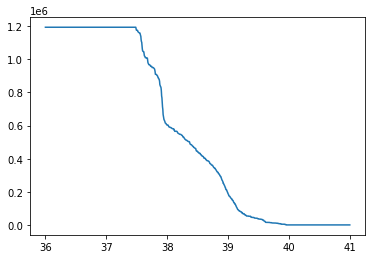

In [258]:
#compute bulk values
#Q_mean = out.Q.mean(axis=0)
bulk = tef.calc_bulk_values(out.var_Q,out.Q)
print(bulk)
#out.q.mean('time').plot()
#Q_test = np.cumsum(out.q.mean('time'))*(out.var_q[1]-out.var_q[0])
#Qs_test = np.cumsum(out2.q.mean('time'))*(out.var_q[1]-out.var_q[0])

out_Q = np.zeros((out.q.shape[0]+1,))
out_Qs = np.zeros((out.q.shape[0]+1,))
for i in range(out.q.shape[0]):
    out_Q[i] = np.sum(out.q[i:] * (out.var_q[1]-out.var_q[0]))
    out_Qs[i] = np.sum(out2.q[i:] * (out2.var_q[1]-out2.var_q[0]))

plt.plot(out.var_Q,out_Q)
bulk2 = tef.calc_bulk_values(out.var_Q,out_Q)
bulk3 = tef.calc_bulk_values(out.var_Q,Qs_test)
print(bulk2.Qin,bulk2.Qout,bulk3.Qin/bulk2.Qin,bulk3.Qout/bulk2.Qout)

In [271]:
#compute olf TEF method:
s_min=36.0
s_max=41.0
N=1024
DeltaS=(s_max-s_min)/N
salt_array=np.arange(s_min+0.5*DeltaS,s_max+0.5*DeltaS,DeltaS)
print(salt_array[-1])
flux = np.ma.masked_invalid(-ds.velx3d.values*ds.hn.values*ds.dyc.values)
salt=np.ma.masked_invalid(ds.salt.values)
print(flux[1,:,0])
q, Q, sq, sQ = sort_by_salinity_fast(salt,flux,
                                                 1024,tmax_auto=1,salinity_array=salt_array)
Q_in_m,Q_out_m,div_sal,ind=calc_bulk_values_new(sQ,Q,1,min_trans='auto')
print(Q_in_m,Q_out_m)


print(sq, out.var_q)

40.99755859375
[-- 144.45501708984375 1176.964111328125 2063.685546875 2531.579345703125
 2105.779296875 1448.128662109375 -30.778581619262695 165.74916076660156
 811.096435546875 894.5535888671875 804.28564453125 730.6036376953125
 746.4135131835938 915.9716186523438 1055.2415771484375 863.4462280273438
 535.5344848632812 253.76199340820312 309.8282470703125 1106.4957275390625
 1275.769775390625 1231.182861328125 1269.9990234375 1286.3858642578125
 1168.32275390625 823.6470947265625 386.047607421875 47.352779388427734 --
 -- -- 106.32363891601562 354.88360595703125 508.2290954589844
 573.1923217773438 572.0330200195312 539.1385498046875 489.4520568847656
 386.6741638183594 241.83941650390625 101.41974639892578
 38.244972229003906 21.30620574951172 18.67777442932129 18.526369094848633
 20.049123764038086 20.996360778808594 19.645544052124023
 4.026042461395264 --]
input is good
tmax 1
min_trans 11934.724228871464
[304 811] ['max' 'min']
[37.48536682 39.95853519]
[1193472.4228871465]
[]

In [ ]:
out = tef.sort_2dim(sort_by_variable=tef.ds.salt,
                    sort_by_variable2=tef.ds.temp,
                    flux = tef.flux,
                    N = 256)

In [ ]:
out.q2.mean("time").plot(x = "var_q", y = "var_q2", cmap = plt.cm.RdBu_r)

In [ ]:
f, ax = plt.subplots(1)
plt.plot(out.q.mean("time").values, out.var_q.values)
ax.invert_yaxis()
ax.set_ylabel("Salinity $[g/kg]$")

In [ ]:
type((0,2))

In [120]:
print(tef.ds.salt.min(),tef.ds.salt.max())

<xarray.DataArray 'salt' ()>
array(36.72302, dtype=float32) <xarray.DataArray 'salt' ()>
array(40.469566, dtype=float32)
